# **Introduction**

## Audio Analysis: Automated Speech Data Exploration

This notebook demonstrates **audio analysis** using a small English audio dataset from Hugging Face. The goal of this notebook is to:

1. **Load an audio dataset** containing short English speech clips and corresponding transcripts.  
   - Dataset used: [vietnhat/gsl-english-podcast-dataset](https://huggingface.co/datasets/vietnhat/gsl-english-podcast-dataset)
2. **Understand the structure** of the audio data and transcripts.
3. **Perform basic preprocessing** on audio clips, including normalization and visualization.
4. **Explore the dataset through EDA (Exploratory Data Analysis)** such as:
   - Duration of audio clips
   - Distribution of transcript lengths
   - Waveform and spectrogram visualization




# **Installing libraries and loading dataset**



- **Installs necessary libraries:**
  - `datasets` → Hugging Face datasets  
  - `librosa` → audio processing  
  - `soundfile` → audio file reading/writing  

- **Imports the libraries**

- **Loads the dataset**

- **Prints dataset structure and available columns**




In [43]:
# Install required libraries
!pip install datasets librosa soundfile --quiet

In [ ]:
!pip install torchcodec --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 23.6 MB/s eta 0:00:00


In [44]:
# Import libraries
from datasets import load_dataset
import librosa
import numpy as np

# Load the dataset
dataset = load_dataset("vietnhat/gsl-english-podcast-dataset")

# Inspect the dataset
print(dataset)

# Check the columns
print("Columns in dataset:", dataset['train'].column_names)

DatasetDict({
    train: Dataset({
        features: ['text', 'audio'],
        num_rows: 186
    })
})
Columns in dataset: ['text', 'audio']


In [ ]:
from datasets import load_dataset, Audio
import IPython.display as ipd

# Load dataset with normal decoding
dataset = load_dataset("vietnhat/gsl-english-podcast-dataset")

# Decode audio into numpy arrays
dataset = dataset.cast_column("audio", Audio(decode=True))

# Access sample
sample = dataset["train"][0]

print("Transcript:", sample["text"])
print("Sampling rate:", sample["audio"]["sampling_rate"])
print("Array shape:", sample["audio"]["array"].shape)

# --- Play the first audio clip ---
print("\nPlaying first audio clip:")
ipd.display(ipd.Audio(
    sample["audio"]["array"],
    rate=sample["audio"]["sampling_rate"]
))

Transcript:  Hello there everyone and welcome back to GSL English. My name is Gideon and in today's lesson
Sampling rate: 16000
Array shape: (143198,)

Playing first audio clip:


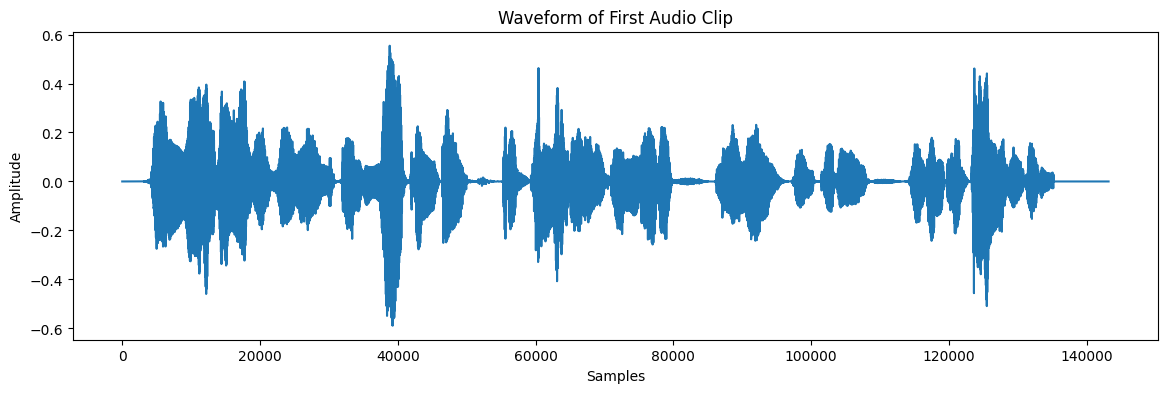

Duration (seconds): 8.949875


In [ ]:
import matplotlib.pyplot as plt


audio = sample["audio"]["array"]
sr = sample["audio"]["sampling_rate"]

plt.figure(figsize=(14, 4))
plt.plot(audio)
plt.title("Waveform of First Audio Clip")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

print("Duration (seconds):", len(audio)/sr)

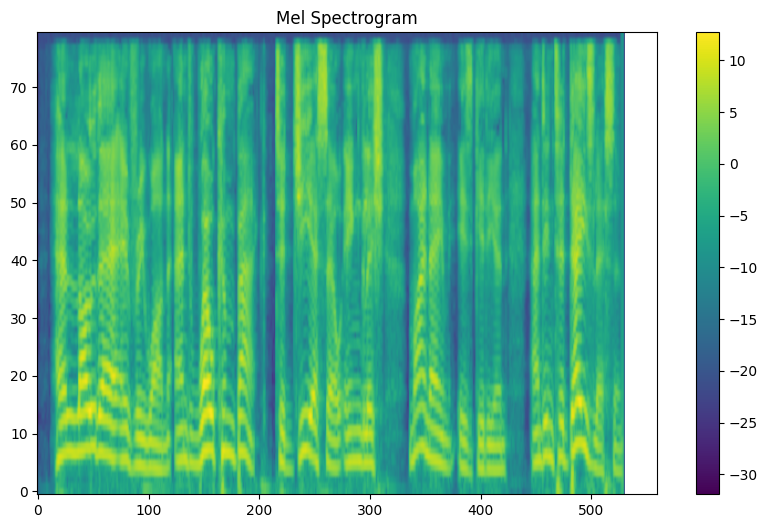

In [ ]:
import torchaudio.transforms as T
import torch

mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=256,
    n_mels=80
)

mel = mel_spectrogram(torch.tensor(audio))

plt.figure(figsize=(10, 6))
plt.imshow(mel.log2().numpy(), aspect='auto', origin='lower')
plt.title("Mel Spectrogram")
plt.colorbar()
plt.show()


# Preprocessing Pipeline

1. **Load audio**
   - Convert from Hugging Face dataset format to NumPy array.

2. **Resample**
   - All clips converted to **16 kHz** for standard speech ML processing.

3. **Convert to mono**
   - Stereo channels combined into a single channel.

4. **Normalize**
   - Amplitude scaled to the range **-1 to 1**.

5. **Noise reduction**
   - Background noise removed.

6. **Silence removal**
   - Non-speech regions removed using an **energy-based threshold**.

7. **Voice Activity Detection (VAD)**
   - Keep only speech segments using **WebRTC VAD**.

8. **Framing & windowing**
   - Audio split into **small overlapping frames** for ML processing.

9. **Feature extraction**
   - **MFCCs (13 coefficients)** are computed.

10. **Pad / Trim**
    - All clips are fixed to **5 seconds** for consistent model input.

11. **Data augmentation**
    - pitch shift, time stretch, added noise.




In [45]:
#Load audio

from datasets import load_dataset, Audio
import numpy as np
import librosa

# Load dataset with decoded audio
dataset = load_dataset("vietnhat/gsl-english-podcast-dataset")
dataset = dataset.cast_column("audio", Audio(decode=True))

train_ds = dataset["train"]

print("Total clips:", len(train_ds))

# Lists to store processed outputs
processed_audio = []   # cleaned, VAD + silence removed + normalized audio
mfcc_features = []     # MFCCs for all clips
metadata = []          # transcripts

# first sample (raw)
first = train_ds[0]
raw_audio = first["audio"]["array"]
raw_sr = first["audio"]["sampling_rate"]

print("Transcript (first clip):", first["text"])
print("Raw sampling rate:", raw_sr)
print("Raw audio shape:", raw_audio.shape)
print("Raw duration:", len(raw_audio)/raw_sr, "sec")


Total clips: 186
Transcript (first clip):  Hello there everyone and welcome back to GSL English. My name is Gideon and in today's lesson
Raw sampling rate: 16000
Raw audio shape: (143198,)
Raw duration: 8.949875 sec


In [46]:

# 2: Resample to 16kHz & convert to mono


target_sr = 16000

resampled_audio = []
resampled_sr = []

for idx, sample in enumerate(train_ds):
    arr = sample["audio"]["array"]
    sr_orig = sample["audio"]["sampling_rate"]

    arr = arr.astype(np.float32)

    if arr.ndim > 1:
        arr = librosa.to_mono(arr)

    if sr_orig != target_sr:
        arr_rs = librosa.resample(arr, orig_sr=sr_orig, target_sr=target_sr)
    else:
        arr_rs = arr

    resampled_audio.append(arr_rs)
    resampled_sr.append(target_sr)

    # Printing first clip to inspect
    if idx == 0:
        print("=== FIRST CLIP INFO (after resample+mono) ===")
        print("Original sampling rate:", sr_orig)
        print("Original shape:", sample["audio"]["array"].shape)
        orig_dur = len(sample["audio"]["array"]) / sr_orig
        print(f"Original duration: {orig_dur:.3f} sec")

        print("\nAfter conversion:")
        print("Target sampling rate:", target_sr)
        print("Resampled shape:", arr_rs.shape)
        new_dur = len(arr_rs) / target_sr
        print(f"New duration: {new_dur:.3f} sec")
        print("Sample (first 10 values):", np.round(arr_rs[:10], 6))
        print("Min, Max:", np.min(arr_rs), np.max(arr_rs))

print("\nTotal clips processed (resample+mono):", len(resampled_audio))


=== FIRST CLIP INFO (after resample+mono) ===
Original sampling rate: 16000
Original shape: (143198,)
Original duration: 8.950 sec

After conversion:
Target sampling rate: 16000
Resampled shape: (143198,)
New duration: 8.950 sec
Sample (first 10 values): [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Min, Max: -0.5890808 0.5542908

Total clips processed (resample+mono): 186


In [47]:

# 3: Normalize volume


normalized_audio = []

for idx, arr in enumerate(resampled_audio):


    peak = np.max(np.abs(arr))
    if peak > 0:
        arr_norm = arr / peak
    else:
        arr_norm = arr

    normalized_audio.append(arr_norm)

    if idx == 0:
        print("=== FIRST CLIP INFO (after normalization) ===")
        print("Before normalization:")
        print("Max amplitude:", np.max(np.abs(resampled_audio[0])))

        print("\nAfter normalization:")
        print("Max amplitude:", np.max(np.abs(arr_norm)))
        print("First 10 samples:", np.round(arr_norm[:10], 6))

print("\nTotal clips normalized:", len(normalized_audio))


=== FIRST CLIP INFO (after normalization) ===
Before normalization:
Max amplitude: 0.5890808

After normalization:
Max amplitude: 1.0
First 10 samples: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

Total clips normalized: 186


In [ ]:
!pip install noisereduce --quiet


In [48]:

# 4: Noise Reduction

import noisereduce as nr


denoised_audio = []

for idx, arr in enumerate(normalized_audio):

    reduced = nr.reduce_noise(y=arr, sr=target_sr)

    denoised_audio.append(reduced)

    if idx == 0:
        print("=== FIRST CLIP INFO (Noise Reduction) ===")
        print("Before noise reduction:")
        print("  Min:", np.min(normalized_audio[0]))
        print("  Max:", np.max(normalized_audio[0]))
        print("  Std Dev:", np.std(normalized_audio[0]))

        print("\nAfter noise reduction:")
        print("  Min:", np.min(reduced))
        print("  Max:", np.max(reduced))
        print("  Std Dev:", np.std(reduced))

print("\nTotal clips noise-reduced:", len(denoised_audio))


=== FIRST CLIP INFO (Noise Reduction) ===
Before noise reduction:
  Min: -1.0
  Max: 0.9409418
  Std Dev: 0.13107406

After noise reduction:
  Min: -0.4655113
  Max: 0.60171413
  Std Dev: 0.048169192

Total clips noise-reduced: 186


In [49]:

# 5: Silence Removal

silence_removed_audio = []

for idx, arr in enumerate(denoised_audio):

    intervals = librosa.effects.split(arr, top_db=20)

    processed = np.concatenate([arr[start:end] for start, end in intervals])

    silence_removed_audio.append(processed)

    if idx == 0:
        print("=== FIRST CLIP INFO (Silence Removal) ===")
        print("Detected non-silent intervals:", intervals)
        print("Before silence removal:", arr.shape)
        print("After silence removal:", processed.shape)

print("\nTotal clips after silence removal:", len(silence_removed_audio))


=== FIRST CLIP INFO (Silence Removal) ===
Detected non-silent intervals: [[  4096  21504]
 [ 22528  29184]
 [ 31744  34304]
 [ 36864  41472]
 [ 41984  45056]
 [ 46080  49664]
 [ 54784  57856]
 [ 59392  69632]
 [ 71680  73728]
 [ 74752  80384]
 [ 87040  93696]
 [102400 105984]
 [114688 122368]
 [122880 129536]
 [131072 133632]]
Before silence removal: (143198,)
After silence removal: (86016,)

Total clips after silence removal: 186


In [ ]:
!pip install webrtcvad


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.2/66.2 kB 2.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for webrtcvad: filename=webrtcvad-2.0.10-cp312-cp312-linux_x86_64.whl size=73519 sha256=61d591d6ab35505d2e6dceeae318267aa95d4c390e3b00e6423444d0aefdf55d
  Stored in directory: /root/.cache/pip/wheels/1e/d3/95/680fa3b16848f1a58d2edaed34c496224c89a9bc63e17b3614
Successfully built webrtcvad


In [50]:

# 6: Voice Activity Detection (VAD)
import webrtcvad
import IPython.display as ipd

vad = webrtcvad.Vad(2)

def apply_vad(audio, sample_rate=16000, frame_ms=30):
    """returning only speech segments."""

    frame_len = int(sample_rate * frame_ms / 1000)
    bytes_audio = (audio * 32768).astype(np.int16).tobytes()

    voiced_frames = []

    for start in range(0, len(audio), frame_len):
        end = start + frame_len
        frame = bytes_audio[start*2:end*2]

        if len(frame) < frame_len * 2:
            break

        if vad.is_speech(frame, sample_rate):
            voiced_frames.append(frame)

    if len(voiced_frames) == 0:
        return np.array([])

    voiced_bytes = b"".join(voiced_frames)
    voiced_audio = np.frombuffer(voiced_bytes, dtype=np.int16) / 32768.0
    return voiced_audio


vad_audio = []

for idx, arr in enumerate(silence_removed_audio):

    processed = apply_vad(arr, sample_rate=16000)
    vad_audio.append(processed)


    if idx == 0:
        print("=== FIRST CLIP INFO (VAD) ===")
        print("Length before VAD:", len(arr))
        print("Length after VAD:", len(processed))

        print("After VAD:")
        ipd.display(ipd.Audio(processed, rate=16000))

print("\nTotal clips after VAD:", len(vad_audio))


=== FIRST CLIP INFO (VAD) ===
Length before VAD: 86016
Length after VAD: 85920
After VAD:



Total clips after VAD: 186


In [51]:

# 7: Framing & Windowing

frame_size_ms = 25
frame_stride_ms = 10
sample_rate = 16000

frame_length = int(sample_rate * frame_size_ms / 1000)
frame_step = int(sample_rate * frame_stride_ms / 1000)

def enframe(audio, frame_length, frame_step, window_fn=np.hamming):
    num_frames = 1 + int((len(audio) - frame_length) / frame_step)
    frames = np.zeros((num_frames, frame_length))
    window = window_fn(frame_length)

    for i in range(num_frames):
        start = i * frame_step
        end = start + frame_length
        frames[i, :] = audio[start:end] * window
    return frames

framed_audio = []

for idx, arr in enumerate(vad_audio):
    frames = enframe(arr, frame_length, frame_step)
    framed_audio.append(frames)

    if idx == 0:
        print("=== FIRST CLIP INFO (Framing & Windowing) ===")
        print("Number of frames:", frames.shape[0])
        print("Frame length (samples):", frames.shape[1])
        print("First frame (first 10 samples):", np.round(frames[0, :10], 6))

print("\nTotal clips framed:", len(framed_audio))


=== FIRST CLIP INFO (Framing & Windowing) ===
Number of frames: 535
Frame length (samples): 400
First frame (first 10 samples): [ 4.20e-05  8.30e-05  1.37e-04  9.60e-05 -2.00e-05 -2.00e-06  7.30e-05
  6.60e-05  8.70e-05  1.60e-04]

Total clips framed: 186


=== FIRST CLIP INFO (MFCCs) ===
MFCC shape: (13, 538)


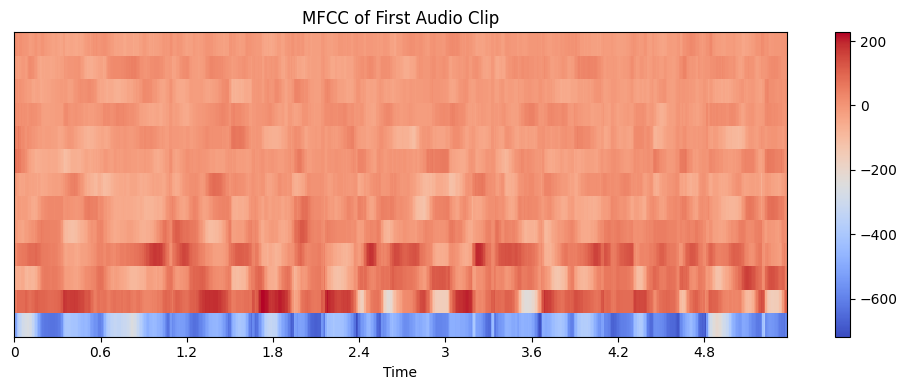


Total clips processed for MFCCs: 186


In [52]:

#8: MFCC Feature Extraction


n_mfcc = 13
n_fft = 512
hop_length = 160

mfcc_features = []

for idx, arr in enumerate(vad_audio):
    mfcc = librosa.feature.mfcc(
        y=arr,
        sr=16000,
        n_mfcc=n_mfcc,
        n_fft=n_fft,
        hop_length=hop_length
    )
    mfcc_features.append(mfcc)


    if idx == 0:
        print("=== FIRST CLIP INFO (MFCCs) ===")
        print("MFCC shape:", mfcc.shape)

        import matplotlib.pyplot as plt
        import librosa.display

        plt.figure(figsize=(10, 4))
        librosa.display.specshow(mfcc, x_axis='time', sr=16000, hop_length=hop_length)
        plt.colorbar()
        plt.title("MFCC of First Audio Clip")
        plt.tight_layout()
        plt.show()

print("\nTotal clips processed for MFCCs:", len(mfcc_features))


In [53]:
# 9: Padding / Trim to Fixed Length

desired_length = 5 * 16000
mfcc_fixed_list = []
audio_fixed_list = []

for idx, arr in enumerate(vad_audio):

    audio_fixed = librosa.util.fix_length(arr, size=desired_length)
    audio_fixed_list.append(audio_fixed)

    mfcc_fixed = librosa.feature.mfcc(
        y=audio_fixed,
        sr=16000,
        n_mfcc=13,
        n_fft=512,
        hop_length=160
    )
    mfcc_fixed_list.append(mfcc_fixed)


    if idx == 0:
        print("=== FIRST CLIP INFO (Pad/Trim to Fixed Length) ===")
        print("Length after fix_length:", len(audio_fixed))
        print("MFCC shape after fixing length:", mfcc_fixed.shape)


=== FIRST CLIP INFO (Pad/Trim to Fixed Length) ===
Length after fix_length: 80000
MFCC shape after fixing length: (13, 501)


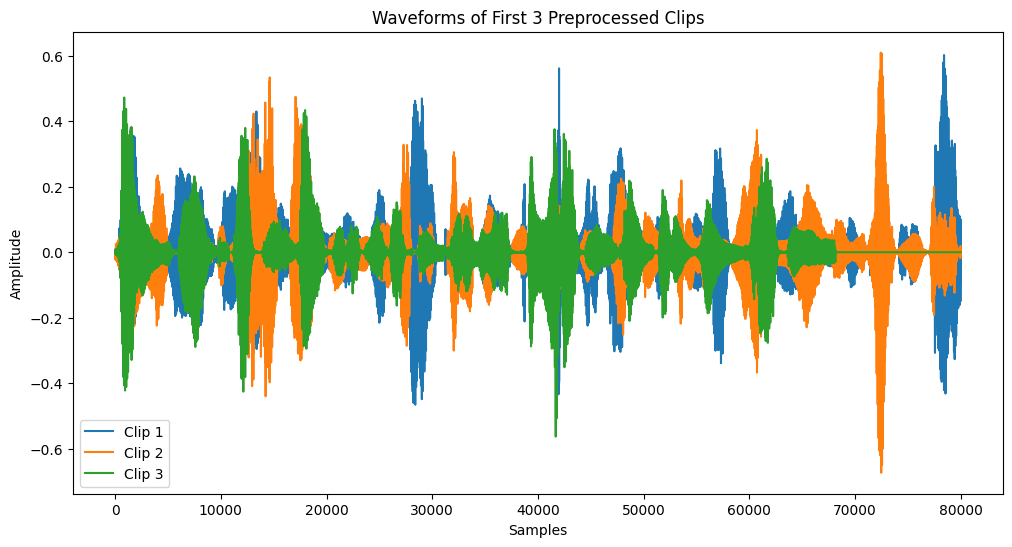

In [ ]:
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(audio_fixed_list[i], label=f'Clip {i+1}')
plt.title("Waveforms of First 3 Preprocessed Clips")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.legend()
plt.show()


In [54]:
#10: Data Augmentation (First Clip )

first_audio = audio_fixed_list[0]

# Pitch Shifting
audio_pitch_up = librosa.effects.pitch_shift(first_audio, sr=16000, n_steps=2)
audio_pitch_down = librosa.effects.pitch_shift(first_audio, sr=16000, n_steps=-2)

# Time Stretching
audio_fast = librosa.effects.time_stretch(first_audio, rate=1.2)
audio_slow = librosa.effects.time_stretch(first_audio, rate=0.8)

# Add Background Noise
noise = 0.005 * np.random.randn(len(first_audio))
audio_noise = first_audio + noise

# Display audio samples using IPython
import IPython.display as ipd

print("Original audio:")
ipd.display(ipd.Audio(first_audio, rate=16000))

print("Pitch shifted +2 semitones:")
ipd.display(ipd.Audio(audio_pitch_up, rate=16000))

print("Pitch shifted -2 semitones:")
ipd.display(ipd.Audio(audio_pitch_down, rate=16000))

print("Time stretched 1.2x:")
ipd.display(ipd.Audio(audio_fast, rate=16000))

print("Time stretched 0.8x:")
ipd.display(ipd.Audio(audio_slow, rate=16000))

print("Added noise:")
ipd.display(ipd.Audio(audio_noise, rate=16000))


Original audio:


Pitch shifted +2 semitones:


Pitch shifted -2 semitones:


Time stretched 1.2x:


Time stretched 0.8x:


Added noise:


EDA

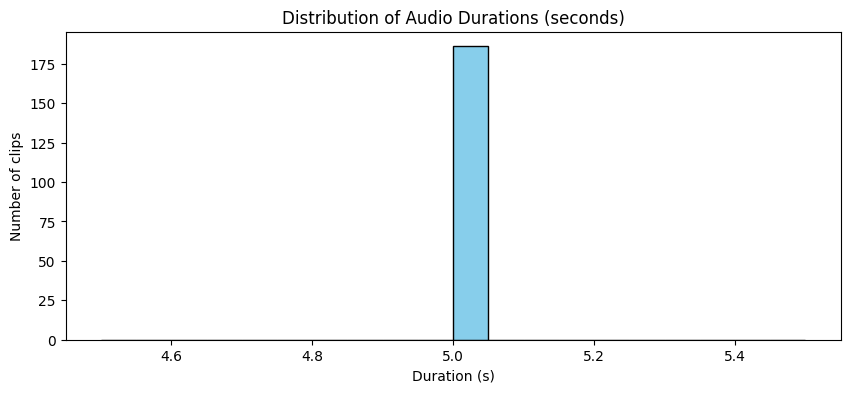

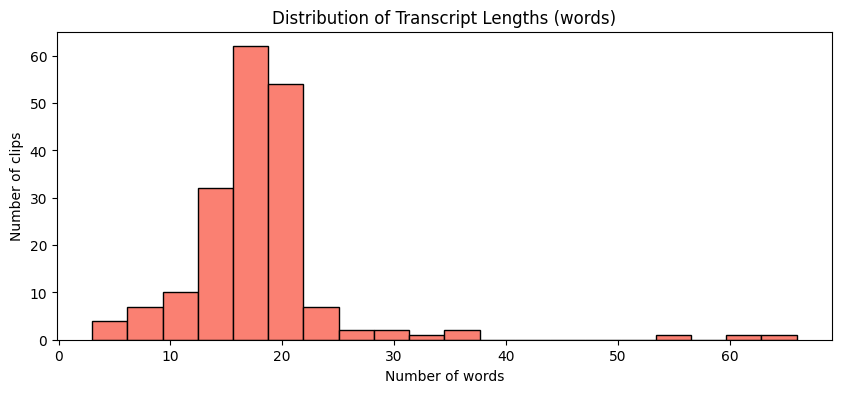

Audio duration (seconds) stats:
Min: 5.0 Max: 5.0 Average: 5.0

Transcript length stats (words):
Min: 3 Max: 66 Average: 17.892473118279568


In [55]:
# 11: EDA - Audio Durations & Transcript Lengths


# Audio durations (seconds) after padding/trimming
durations = [len(a)/16000 for a in audio_fixed_list]

# Transcript lengths (number of words)
transcript_lengths = [len(sample["text"].split()) for sample in dataset["train"]]



# Plot audio durations
plt.figure(figsize=(10,4))
plt.hist(durations, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Audio Durations (seconds)")
plt.xlabel("Duration (s)")
plt.ylabel("Number of clips")
plt.show()

# Plot transcript lengths
plt.figure(figsize=(10,4))
plt.hist(transcript_lengths, bins=20, color='salmon', edgecolor='black')
plt.title("Distribution of Transcript Lengths (words)")
plt.xlabel("Number of words")
plt.ylabel("Number of clips")
plt.show()


print("Audio duration (seconds) stats:")
print("Min:", min(durations), "Max:", max(durations), "Average:", sum(durations)/len(durations))

print("\nTranscript length stats (words):")
print("Min:", min(transcript_lengths), "Max:", max(transcript_lengths), "Average:", sum(transcript_lengths)/len(transcript_lengths))


In [56]:

durations = [len(a)/16000 for a in audio_fixed_list]
means = [np.mean(a) for a in audio_fixed_list]
maxs = [np.max(np.abs(a)) for a in audio_fixed_list]


# Amplitude statistics
print("Amplitude Statistics Across All Clips")
print("Mean amplitude: {:.4f}".format(np.mean(means)))
print("Max amplitude: {:.4f}".format(np.max(maxs)))
print("Min amplitude: {:.4f}".format(np.min(maxs)))







Amplitude Statistics Across All Clips
Mean amplitude: -0.0000
Max amplitude: 0.9734
Min amplitude: 0.4577


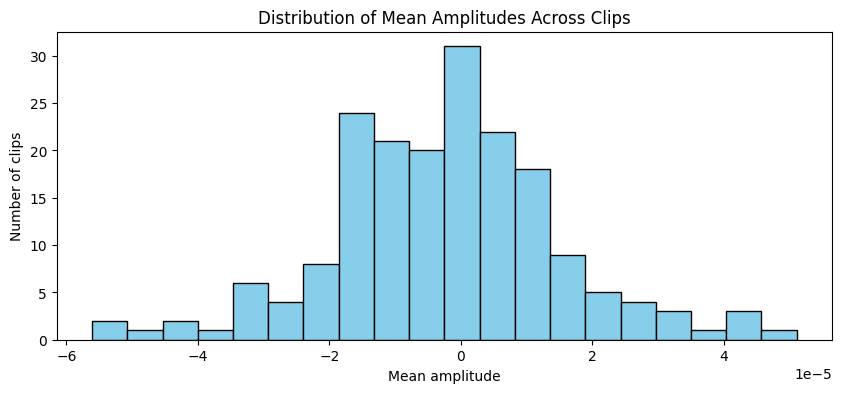

In [57]:

mean_amplitudes = [np.mean(a) for a in audio_fixed_list]

# Histogram of mean amplitudes
plt.figure(figsize=(10,4))
plt.hist(mean_amplitudes, bins=20, color='skyblue', edgecolor='black')
plt.title("Distribution of Mean Amplitudes Across Clips")
plt.xlabel("Mean amplitude")
plt.ylabel("Number of clips")
plt.show()



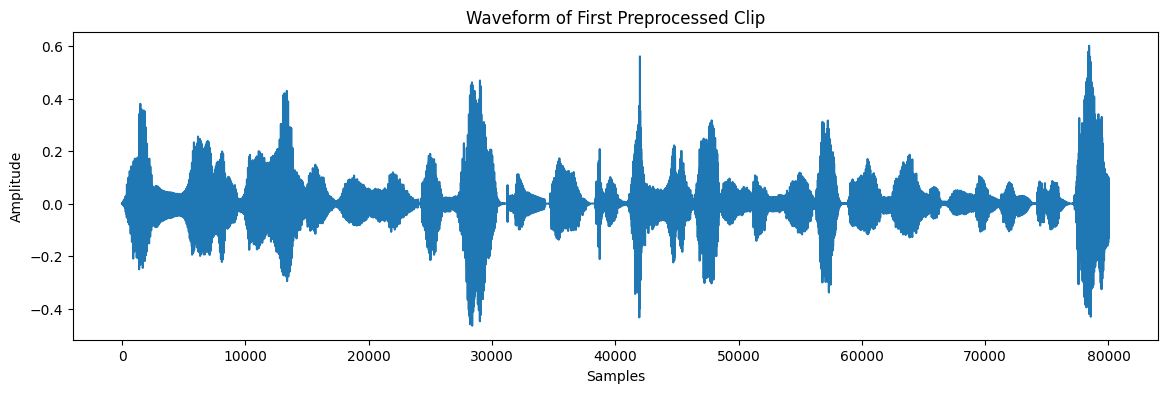

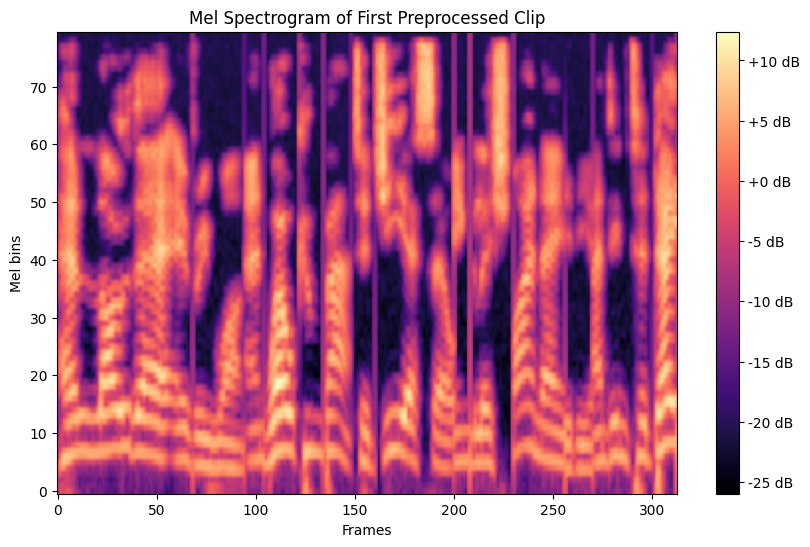

In [59]:


first_clip = audio_fixed_list[0]

first_clip_tensor = torch.tensor(first_clip, dtype=torch.float32)

# Waveform
plt.figure(figsize=(14,4))
plt.plot(first_clip)
plt.title("Waveform of First Preprocessed Clip")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.show()

# Mel Spectrogram
mel_spectrogram = T.MelSpectrogram(
    sample_rate=16000,
    n_fft=1024,
    hop_length=256,
    n_mels=80
)

mel = mel_spectrogram(first_clip_tensor)

plt.figure(figsize=(10,6))
plt.imshow(mel.log2().numpy(), aspect='auto', origin='lower', cmap='magma')
plt.title("Mel Spectrogram of First Preprocessed Clip")
plt.colorbar(format="%+2.0f dB")
plt.xlabel("Frames")
plt.ylabel("Mel bins")
plt.show()

